In [1]:


import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, recall_score, roc_auc_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import warnings
warnings.filterwarnings("ignore")

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


In [2]:
df = pd.read_csv("/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Attribute Information
1. id: unique identifier
2. gender: "Male", "Female" or "Other"
3. age: age of the patient
4. hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5. heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6. ever_married: "No" or "Yes"
7. work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8. Residence_type: "Rural" or "Urban"
9. avg_glucose_level: average glucose level in blood
10. bmi: body mass index
11. smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12. stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


<Axes: >

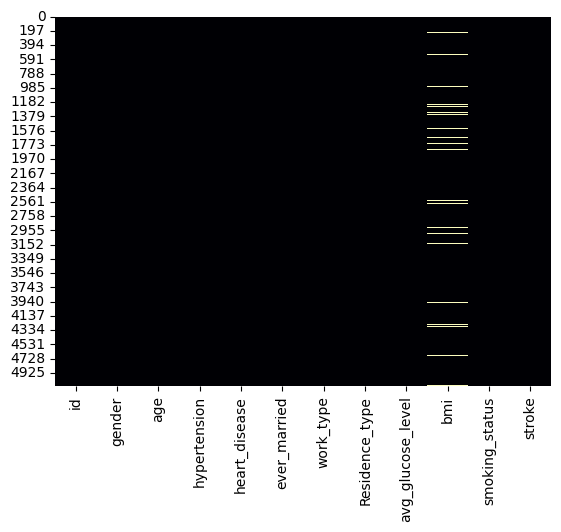

In [4]:
sns.heatmap(df.isna(), cmap='magma', cbar=False)

The dataset consists of 5110 records and 12 columns (11 explanatory & 1 target), 7 numerical and 5 objects. Missing values in bmi features

In [5]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


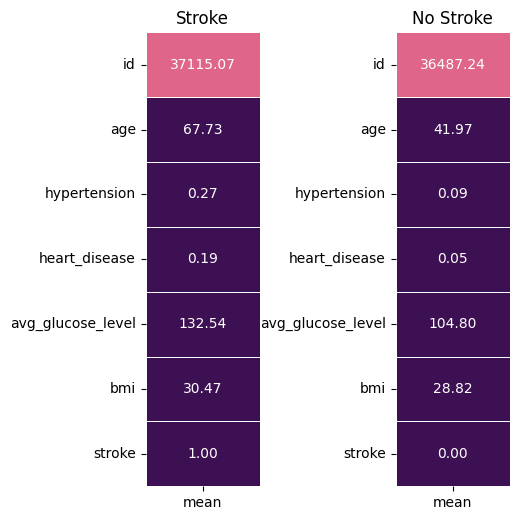

In [6]:
stroke = df[df['stroke'] == 1].describe().T
no_stroke = df[df['stroke'] == 0].describe().T

colors = ['#3C1053','#DF6589']

fig,ax = plt.subplots(1, 2, figsize=(5,5))
plt.subplot(1,2,1)
sns.heatmap(stroke[['mean']], annot=True, cmap=colors, fmt='.2f', cbar=False,linewidths=0.4)
plt.title("Stroke")

plt.subplot(1,2,2)
sns.heatmap(no_stroke[['mean']], annot=True, cmap=colors, fmt='.2f', cbar=False,linewidths=0.4)
plt.title("No Stroke")

plt.tight_layout(pad=0)

* There's quite difference between mean values for **Stroke**(age, hypertension, heart_disease, & avg_glucose) and **No stroke**(age, hypertension, heart_disease, & avg_glucose). 

# Data Visualization

([<matplotlib.axis.XTick at 0x7ff251127be0>,
 [Text(0, 0, 'No Stroke'), Text(1, 0, 'Stroke')])

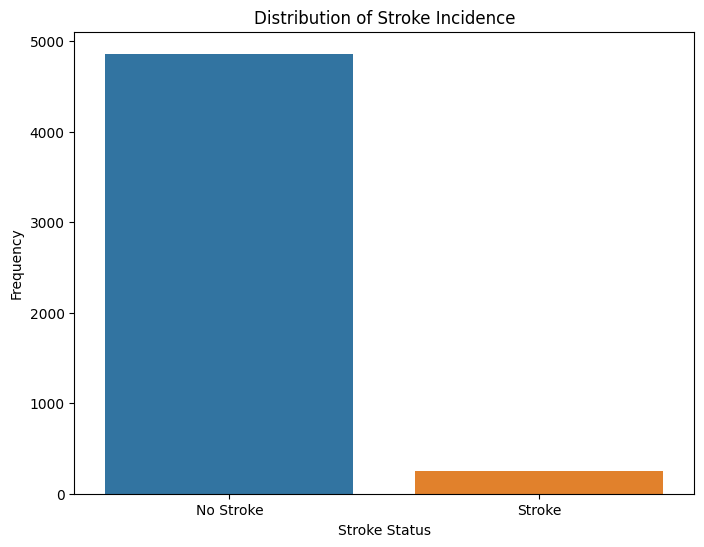

In [7]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='stroke')
plt.title("Distribution of Stroke Incidence")
plt.xlabel("Stroke Status")
plt.ylabel("Frequency")

labels = ['No Stroke', 'Stroke']
plt.xticks(range(len(labels)), labels)

Target  data is highly imbalanced

In [8]:
# drop the error value at gender feature
df = df.loc[(df['gender'] != 'Other')]

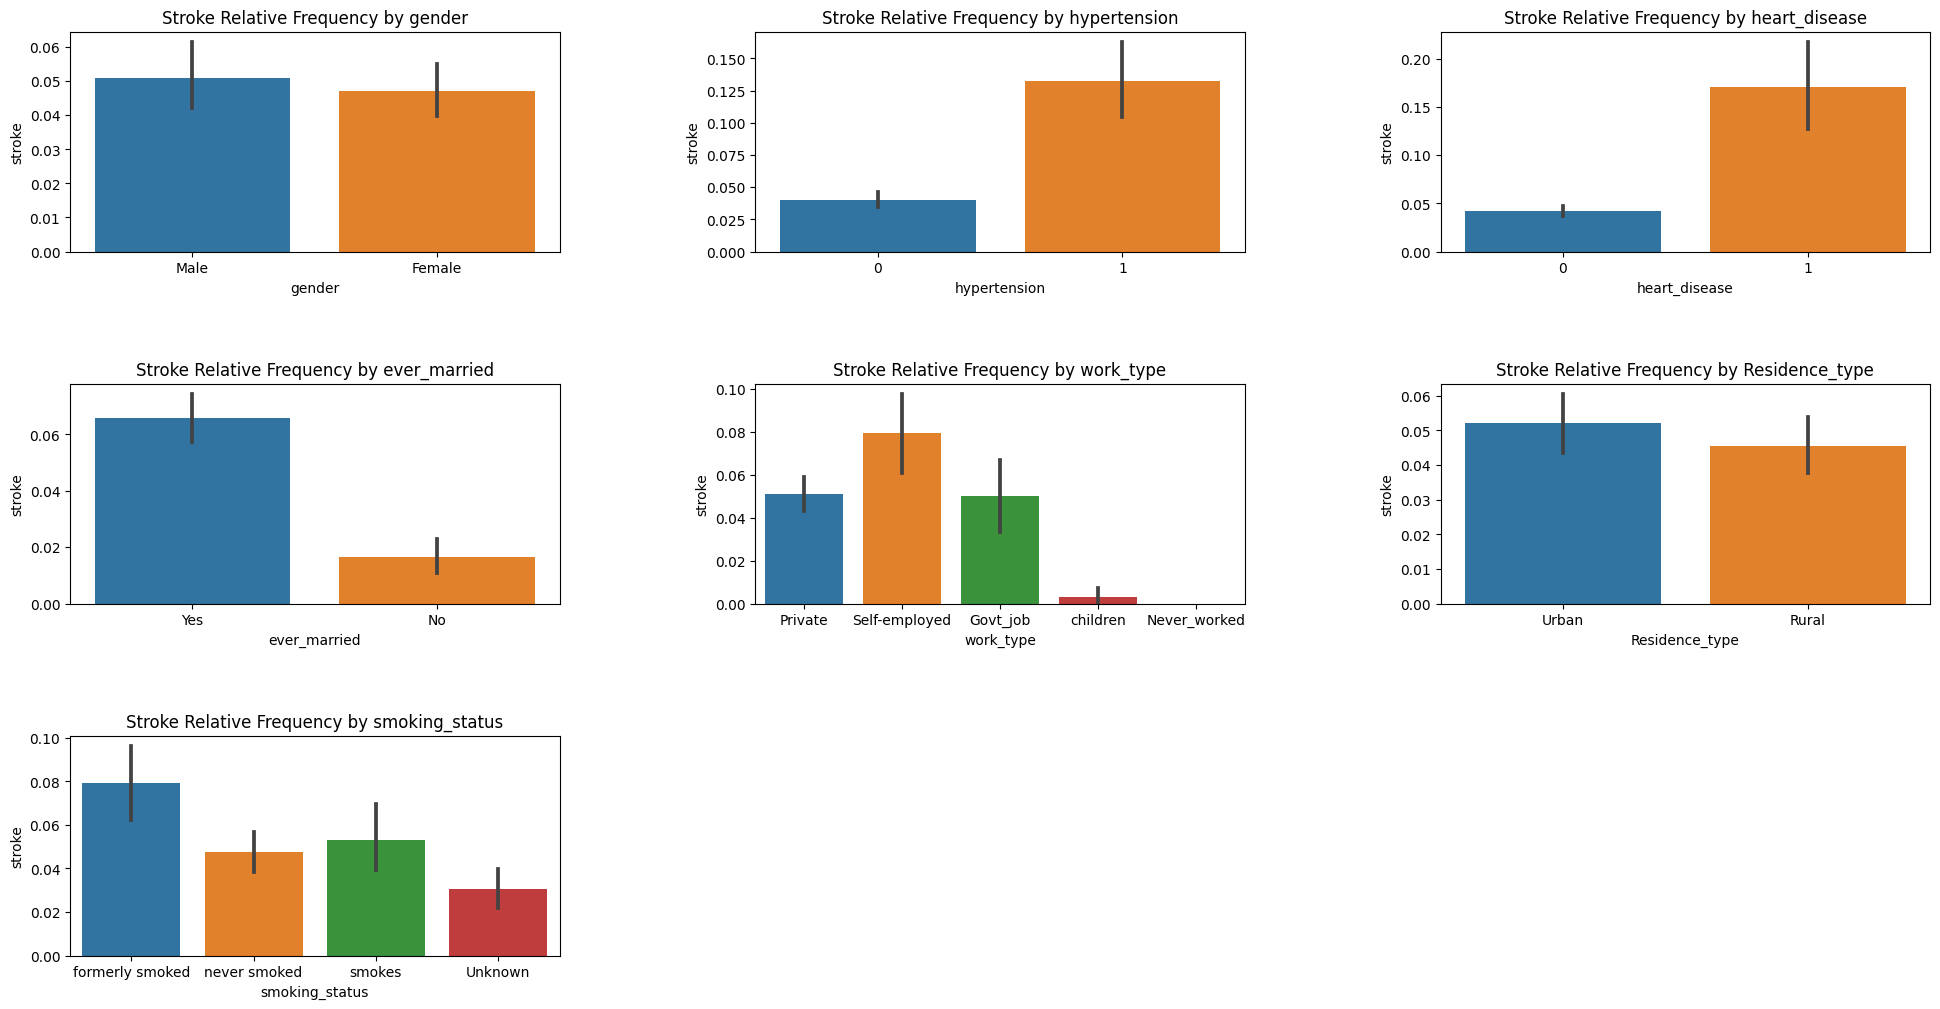

In [9]:
categorical_cols = ['gender', 'hypertension', 'heart_disease', 
                    'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Calculate the number of rows and columns for the grid
num_cols = 3  # Set the number of columns you want in your grid
num_rows = math.ceil(len(categorical_cols) / num_cols)

fig = plt.figure(figsize=(8*num_cols, 4*num_rows))
grid = plt.GridSpec(num_rows, num_cols, wspace=0.4, hspace=0.6)

# Plot each categorical variable
for i, col in enumerate(categorical_cols):
    ax = fig.add_subplot(grid[i])
    sns.barplot(data=df, x=col, y='stroke', ax=ax)
    ax.set_title(f'Stroke Relative Frequency by {col}')

plt.tight_layout()
plt.show()

* Men and women have almost the same chance of stroke
* People who have hypertension and heart disease are more likely to have a stroke
* People who has ever married, smoking_status: formerly smoked, work_type: self-employed. The initial hypothesis for this is that it is age-related ,with older people having a higher likelihood of stroke.
* People who lived at residence types (Urban & Rural) have almost the same chance of stroke

In [10]:
# Proof of the third point
df.groupby(['ever_married', 'smoking_status', 'work_type'])['age'].mean()

ever_married  smoking_status   work_type    
No            Unknown          Govt_job         35.818182
                               Never_worked     15.375000
                               Private          26.188341
                               Self-employed    43.533333
                               children          6.226537
              formerly smoked  Govt_job         41.500000
                               Private          34.663043
                               Self-employed    51.391304
                               children         11.769231
              never smoked     Govt_job         37.882353
                               Never_worked     16.642857
                               Private          28.490411
                               Self-employed    49.978261
                               children         12.537037
              smokes           Govt_job         41.153846
                               Private          30.428571
                           

In [11]:
# Drop id column 
df.drop(columns='id', inplace=True)

<function matplotlib.pyplot.show(close=None, block=None)>

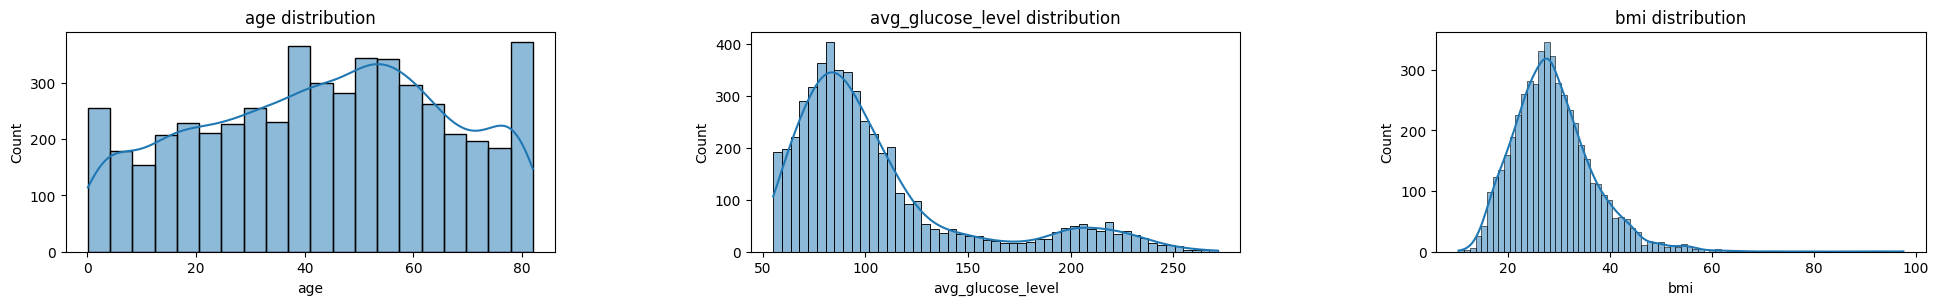

In [12]:
# Distribution for numerical columns
num_col = ['age', 'avg_glucose_level', 'bmi']

row = 3
col = math.ceil(len(num_col)/ row)

fig = plt.figure(figsize=(8*num_cols, 4*num_rows))
grid = plt.GridSpec(num_rows, num_cols, wspace=0.4, hspace=0.6)

for i, col in enumerate(num_col):
    ax = fig.add_subplot(grid[i])
    sns.histplot(data=df, x=col, ax=ax, kde=True)
    ax.set_title(f'{col} distribution')

plt.tight_layout()
plt.show

* avg_glucose_level and bmi are highly skewed

<Axes: >

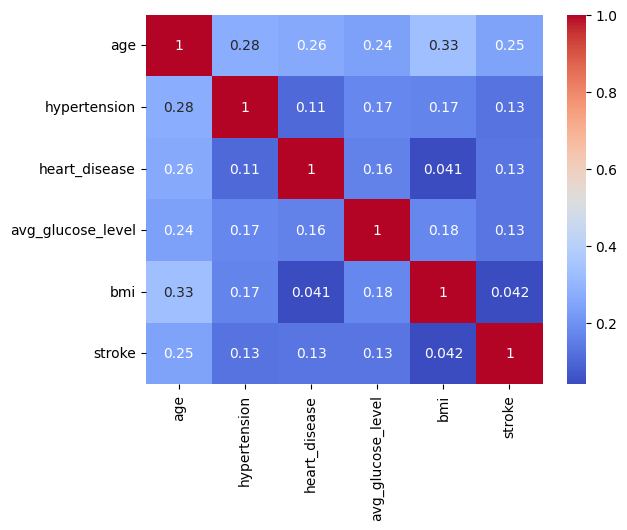

In [13]:
# correlation matrix
num_cols = df.select_dtypes(exclude='object')
corr = num_cols.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

there is no high enough correlations of features

# Data Pre-Processing

In [14]:
# splitting data into train and test set
X = df.drop('stroke', axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)
X_train.shape, X_test.shape

((3831, 10), (1278, 10))

In [15]:
# missing values for bmi in train n test set
print("Training set")
print(X_train.isna().sum())
print('------------------------')
print("Testing set")
print(X_test.isna().sum())

Training set
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  153
smoking_status         0
dtype: int64
------------------------
Testing set
gender                0
age                   0
hypertension          0
heart_disease         0
ever_married          0
work_type             0
Residence_type        0
avg_glucose_level     0
bmi                  48
smoking_status        0
dtype: int64


In [16]:
# Encoding Categorical Features
le = LabelEncoder()
columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for col in columns:
    le.fit(X_train[col])
    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

X_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
1423,1,56.0,1,0,1,2,1,102.37,35.6,2
1110,0,44.0,0,0,1,2,0,90.40,33.1,1
802,1,79.0,0,0,1,3,0,112.64,28.5,1
4196,0,3.0,0,0,0,4,0,131.81,14.1,0
1992,1,64.0,0,1,1,2,1,103.28,34.3,3


In [17]:
# Imputing missing values at bmi feature using KNNimputer
imp = KNNImputer(n_neighbors=5)

imp.fit(X_train)
X_train_imp = imp.transform(X_train)
X_test_imp = imp.transform(X_test)

X_train_imp = pd.DataFrame(X_train_imp, columns=X_train.columns, index=X_train.index)
X_test_imp = pd.DataFrame(X_test_imp, columns=X_test.columns, index=X_test.index)

# Modelling (without sampling technique)

Training score: 1.0
Test score: 0.9154929577464789
Recall Score: 0.22580645161290322
auc-roc Score: 0.5882321731748726
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1216
           1       0.19      0.23      0.21        62

    accuracy                           0.92      1278
   macro avg       0.57      0.59      0.58      1278
weighted avg       0.92      0.92      0.92      1278



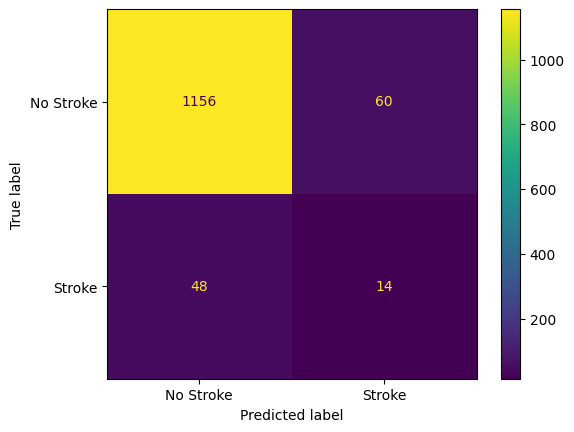

In [18]:
clf_dt = DecisionTreeClassifier(random_state=0)
clf_dt.fit(X_train_imp, y_train)

print(f'Training score: {clf_dt.score(X_train_imp, y_train)}')
print(f'Test score: {clf_dt.score(X_test_imp, y_test)}')
pred_1 = clf_dt.predict(X_test_imp)
print(f'Recall Score: {recall_score(y_test, pred_1)}')
print(f'auc-roc Score: {roc_auc_score(y_test, pred_1)}')
ConfusionMatrixDisplay.from_predictions(y_test, pred_1, display_labels=['No Stroke', 'Stroke'])
print(classification_report(y_test, pred_1))

The model seems fit the training set too well (overfitting) because the difference between training and testing score is quite large. We'll try to tune the decision tree model. Our goal for this model to predict accurately between stroke & non - stroke people also minimize the false negative prediction (Predicted: No-Stroke, True: Stroke). 

In [19]:
# Hyperparameter Tuning with GridSeachCrossValidation using StratifiedKFold

# Decision Tree's parameter that will get tune
params_grid = {
    'class_weight': ['balanced', {0:1, 1:10}, {0:0.5, 1:9.5}],
    'max_depth': np.arange(4,9),
    'min_samples_split': [5, 10, 15, 20]
}

# Stratified KFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# GridSearchCV
best_params = GridSearchCV(clf_dt, param_grid=params_grid, cv=skf, scoring='recall', n_jobs=-1, verbose=1)

# Fitting to training set
best_params.fit(X_train_imp, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'class_weight': ['balanced', {0: 1, 1: 10},
                                          {0: 0.5, 1: 9.5}],
                         'max_depth': array([4, 5, 6, 7, 8]),
                         'min_samples_split': [5, 10, 15, 20]},
             scoring='recall', verbose=1)

In [20]:
best_params.best_score_

0.7594594594594595

In [21]:
# take the best estimator / model 
new_clf_dt = best_params.best_estimator_
results = best_params.cv_results_
result = pd.DataFrame(results)
# result

Training score: 0.6833724876011485
Test score: 0.6713615023474179
Recall Score: 0.8548387096774194
auc-roc Score: 0.7584226443123938
              precision    recall  f1-score   support

           0       0.99      0.66      0.79      1216
           1       0.11      0.85      0.20        62

    accuracy                           0.67      1278
   macro avg       0.55      0.76      0.50      1278
weighted avg       0.95      0.67      0.76      1278



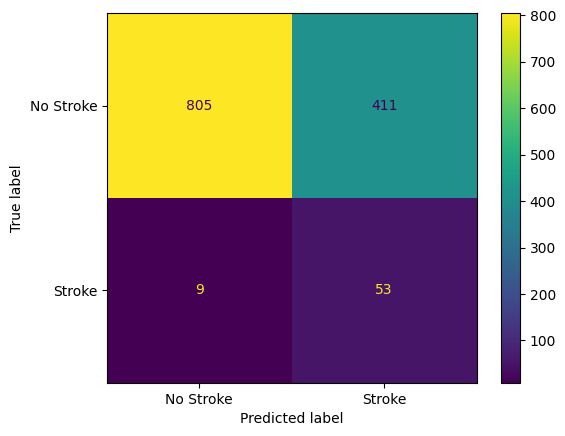

In [22]:
print(f'Training score: {new_clf_dt.score(X_train_imp, y_train)}')
print(f'Test score: {new_clf_dt.score(X_test_imp, y_test)}')
pred_2 = new_clf_dt.predict(X_test_imp)
print(f'Recall Score: {recall_score(y_test, pred_2)}')
print(f'auc-roc Score: {roc_auc_score(y_test, pred_2)}')
ConfusionMatrixDisplay.from_predictions(y_test, pred_2, display_labels=['No Stroke', 'Stroke'])
print(classification_report(y_test, pred_2))

# Modelling (with samling technique)

In [23]:
und = RandomUnderSampler(sampling_strategy={0:1500}, random_state=0)
Sm = SMOTE(random_state=0, sampling_strategy='auto')

X_res, y_res = und.fit_resample(X_train_imp, y_train)
X_ress, y_ress = Sm.fit_resample(X_res, y_res)

In [24]:
y_ress.value_counts()

stroke
0    1500
1    1500
Name: count, dtype: int64

Training score: 1.0
Test score: 0.8560250391236307
Recall Score: 0.3064516129032258
auc-roc Score: 0.5952488327674025
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      1216
           1       0.12      0.31      0.17        62

    accuracy                           0.86      1278
   macro avg       0.54      0.60      0.55      1278
weighted avg       0.92      0.86      0.88      1278



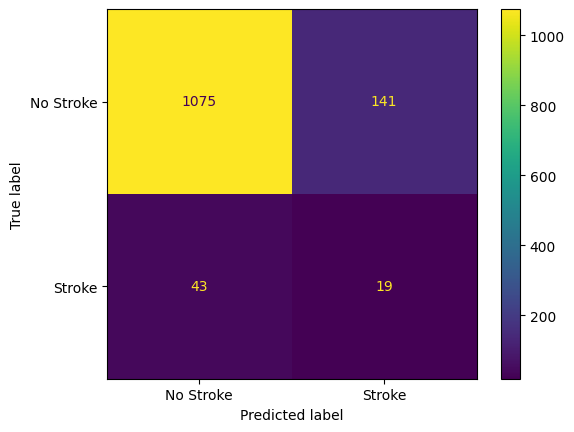

In [25]:
clf_dt_1 = DecisionTreeClassifier(random_state=0)
clf_dt_1.fit(X_ress, y_ress)

print(f'Training score: {clf_dt_1.score(X_ress, y_ress)}')
print(f'Test score: {clf_dt_1.score(X_test_imp, y_test)}')
pred_3 = clf_dt_1.predict(X_test_imp)
print(f'Recall Score: {recall_score(y_test, pred_3)}')
print(f'auc-roc Score: {roc_auc_score(y_test, pred_3)}')
ConfusionMatrixDisplay.from_predictions(y_test, pred_3, display_labels=['No Stroke', 'Stroke'])
print(classification_report(y_test, pred_3))

In [26]:
# Hyperparameter Tuning with GridSeachCrossValidation using StratifiedKFold

# Decision Tree's parameter that will get tune
params_grid = {
    'class_weight': ['balanced', {0:1, 1:10}, {0:0.5, 1:9.5}],
    'max_depth': np.arange(4,9),
    'min_samples_split': [5, 10, 15, 20]
}

# Stratified KFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# GridSearchCV
best_params_1 = GridSearchCV(clf_dt, param_grid=params_grid, cv=skf, scoring='recall', n_jobs=-1, verbose=1)

# Fitting to training set
best_params_1.fit(X_ress, y_ress)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'class_weight': ['balanced', {0: 1, 1: 10},
                                          {0: 0.5, 1: 9.5}],
                         'max_depth': array([4, 5, 6, 7, 8]),
                         'min_samples_split': [5, 10, 15, 20]},
             scoring='recall', verbose=1)

Training score: 0.6946666666666667
Test score: 0.4287949921752739
Recall Score: 0.9838709677419355
auc-roc Score: 0.6921821943972835
              precision    recall  f1-score   support

           0       1.00      0.40      0.57      1216
           1       0.08      0.98      0.14        62

    accuracy                           0.43      1278
   macro avg       0.54      0.69      0.36      1278
weighted avg       0.95      0.43      0.55      1278



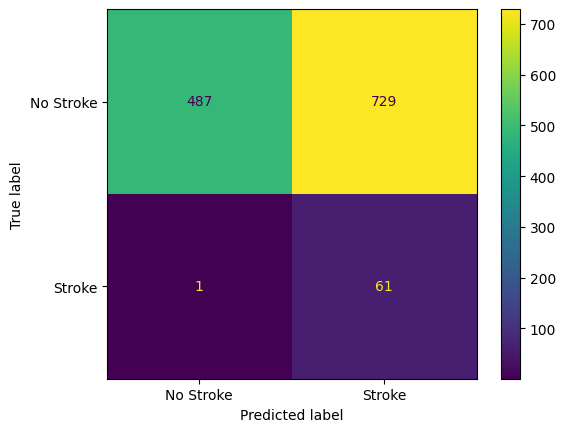

In [27]:
new_clf_dt_1 = best_params_1.best_estimator_

print(f'Training score: {new_clf_dt_1.score(X_ress, y_ress)}')
print(f'Test score: {new_clf_dt_1.score(X_test_imp, y_test)}')
pred_4 = new_clf_dt_1.predict(X_test_imp)
print(f'Recall Score: {recall_score(y_test, pred_4)}')
print(f'auc-roc Score: {roc_auc_score(y_test, pred_4)}')
ConfusionMatrixDisplay.from_predictions(y_test, pred_4, display_labels=['No Stroke', 'Stroke'])
print(classification_report(y_test, pred_4))